In [1]:
import inspect

import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

EPS = 1e-3
FEATURE_SELECTION_PERCENTILE = 30

In [2]:
def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def custom_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / (ss_tot + EPS)

def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + EPS))) * 100

In [3]:
class CustomLinearRegression:
    def __init__(self, method='analytical', lr=0.01, epochs=1000, batch_size=32, verbose=False):
        self.method = method  # 'analytical', 'gd', 'sgd'
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.verbose = verbose
        self.loss_history = []

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        if self.method == 'analytical':
            X_b = np.c_[np.ones((n_samples, 1)), X]
            theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
            self.bias = theta[0]
            self.weights = theta[1:]

        elif self.method in ['gd', 'sgd']:
            self.weights = np.zeros(n_features)
            self.bias = 0

            for epoch in range(self.epochs):
                if self.method == 'gd':
                    y_pred = np.dot(X, self.weights) + self.bias
                    error = y_pred - y
                    
                    dw = (2 / n_samples) * np.dot(X.T, error)
                    db = (2 / n_samples) * np.sum(error)
                    
                    self.weights -= self.lr * dw
                    self.bias -= self.lr * db

                elif self.method == 'sgd':
                    indices = np.arange(n_samples)
                    np.random.shuffle(indices)
                    X_shuffled = X[indices]
                    y_shuffled = y[indices]

                    for i in range(0, n_samples, self.batch_size):
                        X_batch = X_shuffled[i:i+self.batch_size]
                        y_batch = y_shuffled[i:i+self.batch_size]
                        
                        y_pred = np.dot(X_batch, self.weights) + self.bias
                        error = y_pred - y_batch
                        
                        dw = (2 / len(X_batch)) * np.dot(X_batch.T, error)
                        db = (2 / len(X_batch)) * np.sum(error)
                        
                        self.weights -= self.lr * dw
                        self.bias -= self.lr * db
                
                if self.verbose and epoch % 100 == 0:
                    current_pred = np.dot(X, self.weights) + self.bias
                    loss = np.mean((y - current_pred)**2)
                    self.loss_history.append(loss)
                    print(f"Epoch {epoch}: Loss = {loss}")

    def predict(self, X):
        X = np.array(X)
        return np.dot(X, self.weights) + self.bias

In [4]:
def signed_log1p(data: np.ndarray) -> np.ndarray:
    return np.sign(data) * np.log1p(np.abs(data))


def extract_date_parts(df: pd.DataFrame, column: str) -> None:
    if column not in df.columns:
        return

    parsed = pd.to_datetime(df[column], errors="coerce")
    df[f"{column}_Year"] = parsed.dt.year
    df[f"{column}_Month"] = parsed.dt.month
    df[f"{column}_DayOfWeek"] = parsed.dt.dayofweek

    df.drop(columns=[column], inplace=True)


def add_bins(df: pd.DataFrame, column: str, bins: list, fmt: str = "num") -> None:
    if column not in df.columns:
        return

    labels = []
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        if np.isinf(hi):
            labels.append(f"{lo}{'+' if fmt=='num' else ''}")
        else:
            labels.append(f"{lo}-{hi}")

    df[f"{column}Band"] = (
        pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
        .astype(str)
    )


def augment_features(df: pd.DataFrame) -> None:
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + EPS)

    total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtServiceRatio"] = total_debt / (df["MonthlyIncome"] + EPS)
    df["DisposableIncome"] = df["MonthlyIncome"] - total_debt

    df["AssetCoverage"] = df["TotalAssets"] / (df["TotalLiabilities"] + EPS)
    df["LiabilityGap"] = df["TotalLiabilities"] - df["TotalAssets"]
    
    df["SignedLogLiabilityGap"] = signed_log1p(df["LiabilityGap"]) 
    df.drop(columns=["LiabilityGap"], inplace=True)

    df["NetWorthToLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToIncome"] = df["NetWorth"] / (df["AnnualIncome"] + EPS)

    df["UtilizationPerLine"] = df["CreditCardUtilizationRate"] / (df["NumberOfOpenCreditLines"] + 1)

    df["InquiryPerLine"] =  df["NumberOfCreditInquiries"] / (df["NumberOfOpenCreditLines"] + 1)

    df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExperienceToAge"] = df["Experience"] / (df["Age"] + EPS)
    df["LoanDurationYears"] = df["LoanDuration"] / 12.0

    df["CreditHistoryToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + EPS)

    df["IncomeDiscrepancy"] = df["AnnualIncome"] - (df["MonthlyIncome"] * 12.0)
    
    df["AgeAfterExperience"] = df["Age"] - df["Experience"] 

    parsed = pd.to_datetime(df["ApplicationDate"], errors="coerce")
    df["ApplicationDateWeek"] = parsed.dt.isocalendar().week.astype(float)
    df["ApplicationDateDayOfYear"] = parsed.dt.dayofyear
    df["ApplicationDateQuarter"] = parsed.dt.quarter

    add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])
    add_bins(df, "AnnualIncome", [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf])
    add_bins(df, "TotalDebtToIncomeRatio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf])
    add_bins(df, "InterestRate", [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf])
    add_bins(df, "Age", [18, 30, 45, 60, np.inf])
    add_bins(df, "LoanAmount", [0, 30000, 60000, 100000, np.inf])
    add_bins(df, "MonthlyIncome", [0, 2000, 4000, 6000, 8000, 12000, 16000, 25000, np.inf])
    add_bins(df, "CreditCardUtilizationRate", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, np.inf])

In [5]:
class ManualPipeline:
    def __init__(self, reg_method='sklearn', lr=0.01, epochs=1000, batch_size=32, verbose=False, scaler_type='zscore'):
        self.reg_method = reg_method
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.scaler_type = scaler_type
        self.num_medians = None
        self.cat_modes = None
        self.num_mean = None
        self.num_std = None
        self.num_min = None
        self.num_max = None
        self.poly = None
        self.poly_mean = None
        self.poly_std = None
        self.ohe = None
        self.selector = None
        self.reg = None

    def fit(self, X, y, numeric_cols, cat_cols):
        self.num_medians = X[numeric_cols].median()
        X[numeric_cols] = X[numeric_cols].fillna(self.num_medians)

        self.cat_modes = X[cat_cols].mode().iloc[0]
        X[cat_cols] = X[cat_cols].fillna(self.cat_modes)

        X[numeric_cols] = np.sign(X[numeric_cols]) * np.log1p(np.abs(X[numeric_cols]))

        if self.scaler_type == 'zscore':
            self.num_mean = X[numeric_cols].mean()
            self.num_std = X[numeric_cols].std().replace(0, 1)
            X[numeric_cols] = (X[numeric_cols] - self.num_mean) / self.num_std
        elif self.scaler_type == 'minmax':
            self.num_min = X[numeric_cols].min()
            self.num_max = X[numeric_cols].max()
            X[numeric_cols] = (X[numeric_cols] - self.num_min) / (self.num_max - self.num_min + EPS)

        self.poly = PolynomialFeatures(degree=2, include_bias=False)
        self.poly.fit(X[numeric_cols])
        poly_train = self.poly.transform(X[numeric_cols])
        poly_cols = self.poly.get_feature_names_out(numeric_cols)
        poly_df = pd.DataFrame(poly_train, columns=poly_cols, index=X.index)

        self.poly_mean = poly_df.mean()
        self.poly_std = poly_df.std().replace(0, 1)
        poly_df = (poly_df - self.poly_mean) / self.poly_std

        ohe_kwargs = {"handle_unknown": "ignore"}
        if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
            ohe_kwargs["sparse_output"] = False
        else:
            ohe_kwargs["sparse"] = False
        self.ohe = OneHotEncoder(**ohe_kwargs)
        self.ohe.fit(X[cat_cols])
        cat_encoded = self.ohe.transform(X[cat_cols])
        cat_cols_encoded = self.ohe.get_feature_names_out(cat_cols)
        cat_df = pd.DataFrame(cat_encoded, columns=cat_cols_encoded, index=X.index)

        X_full = pd.concat([poly_df, cat_df], axis=1)

        self.selector = SelectPercentile(score_func=f_regression, percentile=FEATURE_SELECTION_PERCENTILE)
        self.selector.fit(X_full, y)
        X_sel = self.selector.transform(X_full)

        if self.reg_method == 'sklearn':
            self.reg = LinearRegression()
        else:
            self.reg = CustomLinearRegression(method=self.reg_method, lr=self.lr, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        self.reg.fit(X_sel, y)

    def transform(self, X, numeric_cols, cat_cols):
        X[numeric_cols] = X[numeric_cols].fillna(self.num_medians)
        X[cat_cols] = X[cat_cols].fillna(self.cat_modes)

        X[numeric_cols] = np.sign(X[numeric_cols]) * np.log1p(np.abs(X[numeric_cols]))

        if self.scaler_type == 'zscore':
            X[numeric_cols] = (X[numeric_cols] - self.num_mean) / self.num_std
        elif self.scaler_type == 'minmax':
            X[numeric_cols] = (X[numeric_cols] - self.num_min) / (self.num_max - self.num_min + EPS)

        poly_test = self.poly.transform(X[numeric_cols])
        poly_cols = self.poly.get_feature_names_out(numeric_cols)
        poly_df = pd.DataFrame(poly_test, columns=poly_cols, index=X.index)

        poly_df = (poly_df - self.poly_mean) / self.poly_std

        cat_encoded = self.ohe.transform(X[cat_cols])
        cat_cols_encoded = self.ohe.get_feature_names_out(cat_cols)
        cat_df = pd.DataFrame(cat_encoded, columns=cat_cols_encoded, index=X.index)

        X_full = pd.concat([poly_df, cat_df], axis=1)

        X_sel = self.selector.transform(X_full)

        return X_sel

    def predict(self, X, numeric_cols, cat_cols):
        X_sel = self.transform(X, numeric_cols, cat_cols)
        return self.reg.predict(X_sel)

In [6]:
class CustomCrossValidator:
    def __init__(self, cv_type='kfold', n_splits=5, shuffle=True, random_state=43):
        self.cv_type = cv_type
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n = len(X)
        indices = np.arange(n)
        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(indices)
        if self.cv_type == 'kfold':
            fold_sizes = np.full(self.n_splits, n // self.n_splits, dtype=int)
            fold_sizes[:n % self.n_splits] += 1
            current = 0
            for fold_size in fold_sizes:
                start, stop = current, current + fold_size
                test_idx = indices[start:stop]
                train_idx = np.concatenate((indices[:start], indices[stop:]))
                yield train_idx, test_idx
                current = stop
        elif self.cv_type == 'loo':
            for i in range(n):
                test_idx = [indices[i]]
                train_idx = np.delete(indices, i)
                yield train_idx, test_idx

In [7]:
def perform_eda(df, target_column):
    plt.figure(figsize=(8, 5))
    sns.histplot(df['RiskScore'], kde=True, color='blue')
    plt.title('RiskScore')
    plt.show()

    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()

    
    print("Top positive correlations with RiskScore:")
    print(corr[target_column].sort_values(ascending=False).head(10))
    print("Top negative correlations with RiskScore:")
    print(corr[target_column].sort_values(ascending=True).head(10))

    plt.figure(figsize=(50, 50))
    corr_matrix = df[numeric_df.columns].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Corr matrix', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    

    key_features = [
        'CreditScore', 'AnnualIncome', 'LoanAmount', 'InterestRate',
        'TotalDebtToIncomeRatio', 'DebtToIncomeRatio', 'MonthlyDebtPayments',
        'Age', 'NetWorth', 'TotalAssets', 'PaymentHistory',
        'NumberOfCreditInquiries', 'SavingsAccountBalance', 'Experience'
    ]
    key_features = [f for f in key_features if f in df.columns]

    n_features = len(key_features)
    plots_per_page = 9
    n_pages = (n_features + plots_per_page - 1) // plots_per_page

    for page in range(n_pages):
        start_idx = page * plots_per_page
        end_idx = min(start_idx + plots_per_page, n_features)
        current_features = key_features[start_idx:end_idx]

        fig, axes = plt.subplots(3, 3, figsize=(20, 18))
        axes = axes.flatten()

        for idx, feature in enumerate(current_features):
            ax = axes[idx]
            if feature == 'CreditScore':
                partner = 'InterestRate'
                hue = 'LoanAmount'
            elif feature == 'AnnualIncome':
                partner = 'LoanAmount'
                hue = None
            elif feature == 'TotalDebtToIncomeRatio':
                partner = 'InterestRate'
                hue = None
            elif feature == 'Age':
                partner = 'CreditScore'
                hue = None
            elif feature == 'NetWorth':
                partner = 'TotalAssets'
                hue = None
            elif feature == 'PaymentHistory':
                partner = 'NumberOfCreditInquiries'
                hue = None
            else:
                partner = 'InterestRate' if 'InterestRate' in df.columns else 'CreditScore'
                hue = None

            if partner in df.columns:
                sns.scatterplot(
                    data=df.sample(min(10000, len(df)), random_state=42),
                    x=feature,
                    y=partner,
                    hue=hue,
                    alpha=0.6,
                    ax=ax,
                    palette='viridis' if hue else None,
                    size=hue,
                    sizes=(10, 100) if hue else None,
                    legend=False if hue is None else True
                )
            else:
                sns.histplot(df[feature], kde=True, ax=ax, color='gray')

            ax.set_title(f"{feature} vs {partner}", fontsize=14, pad=10)
            ax.set_xlabel(feature)
            ax.set_ylabel(partner)

        for j in range(idx + 1, 9):
            axes[j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    plt.figure(figsize=(18, 12))

    plt.subplot(2, 3, 1)
    plt.subplot(2, 3, 1)
    sns.scatterplot(data=df, x='CreditScore', y='InterestRate', alpha=0.6, hue='LoanAmount', palette='viridis', size='LoanAmount', sizes=(10, 100))
    plt.title('CreditScore vs InterestRate')

    plt.subplot(2, 3, 2)
    sns.scatterplot(data=df, x='AnnualIncome', y='LoanAmount', alpha=0.6, color='green')
    plt.title('AnnualIncome vs LoanAmount')
    plt.xscale('log') if (df['AnnualIncome'] > 0).all() else None

    plt.subplot(2, 3, 3)
    sns.scatterplot(data=df, x='TotalDebtToIncomeRatio', y='InterestRate', alpha=0.6, color='red')
    plt.title('TotalDebtToIncomeRatio vs InterestRate')

    plt.subplot(2, 3, 4)
    sns.boxplot(data=df, x='Age', y='CreditScore')
    plt.title('CreditScore по возрасту')

    plt.subplot(2, 3, 5)
    sns.scatterplot(data=df, x='NetWorth', y='TotalAssets', alpha=0.6, color='purple')
    plt.title('NetWorth vs TotalAssets')

    plt.subplot(2, 3, 6)
    sns.scatterplot(data=df, x='PaymentHistory', y='NumberOfCreditInquiries', alpha=0.6, color='orange')
    plt.title('PaymentHistory vs NumberOfCreditInquiries')

    plt.tight_layout()
    plt.show()

The target variable is not in the range from 0 to 100. Needs to process emissions.


The maximum modulo correlation is only 0.019. The risk is not determined by one or two dominant factors.
Nonlinear transformations and feature interactions are necessary for good model quality.

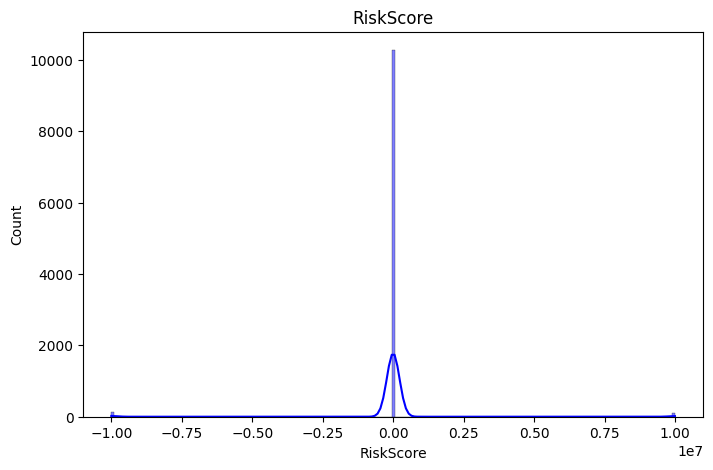

Top positive correlations with RiskScore:
RiskScore                    1.000000
PaymentHistory               0.019144
TotalDebtToIncomeRatio       0.013879
MonthlyLoanPayment           0.012366
LoanAmount                   0.011771
NumberOfCreditInquiries      0.011055
NetWorth                     0.008804
TotalAssets                  0.008092
SavingsAccountBalance        0.007611
CreditCardUtilizationRate    0.005501
Name: RiskScore, dtype: float64
Top negative correlations with RiskScore:
NumberOfDependents           -0.023314
UtilityBillsPaymentHistory   -0.013865
LengthOfCreditHistory        -0.009448
AnnualIncome                 -0.008460
DebtToIncomeRatio            -0.007417
MonthlyIncome                -0.006145
PreviousLoanDefaults         -0.005409
Experience                   -0.005408
TotalLiabilities             -0.004976
Age                          -0.004648
Name: RiskScore, dtype: float64


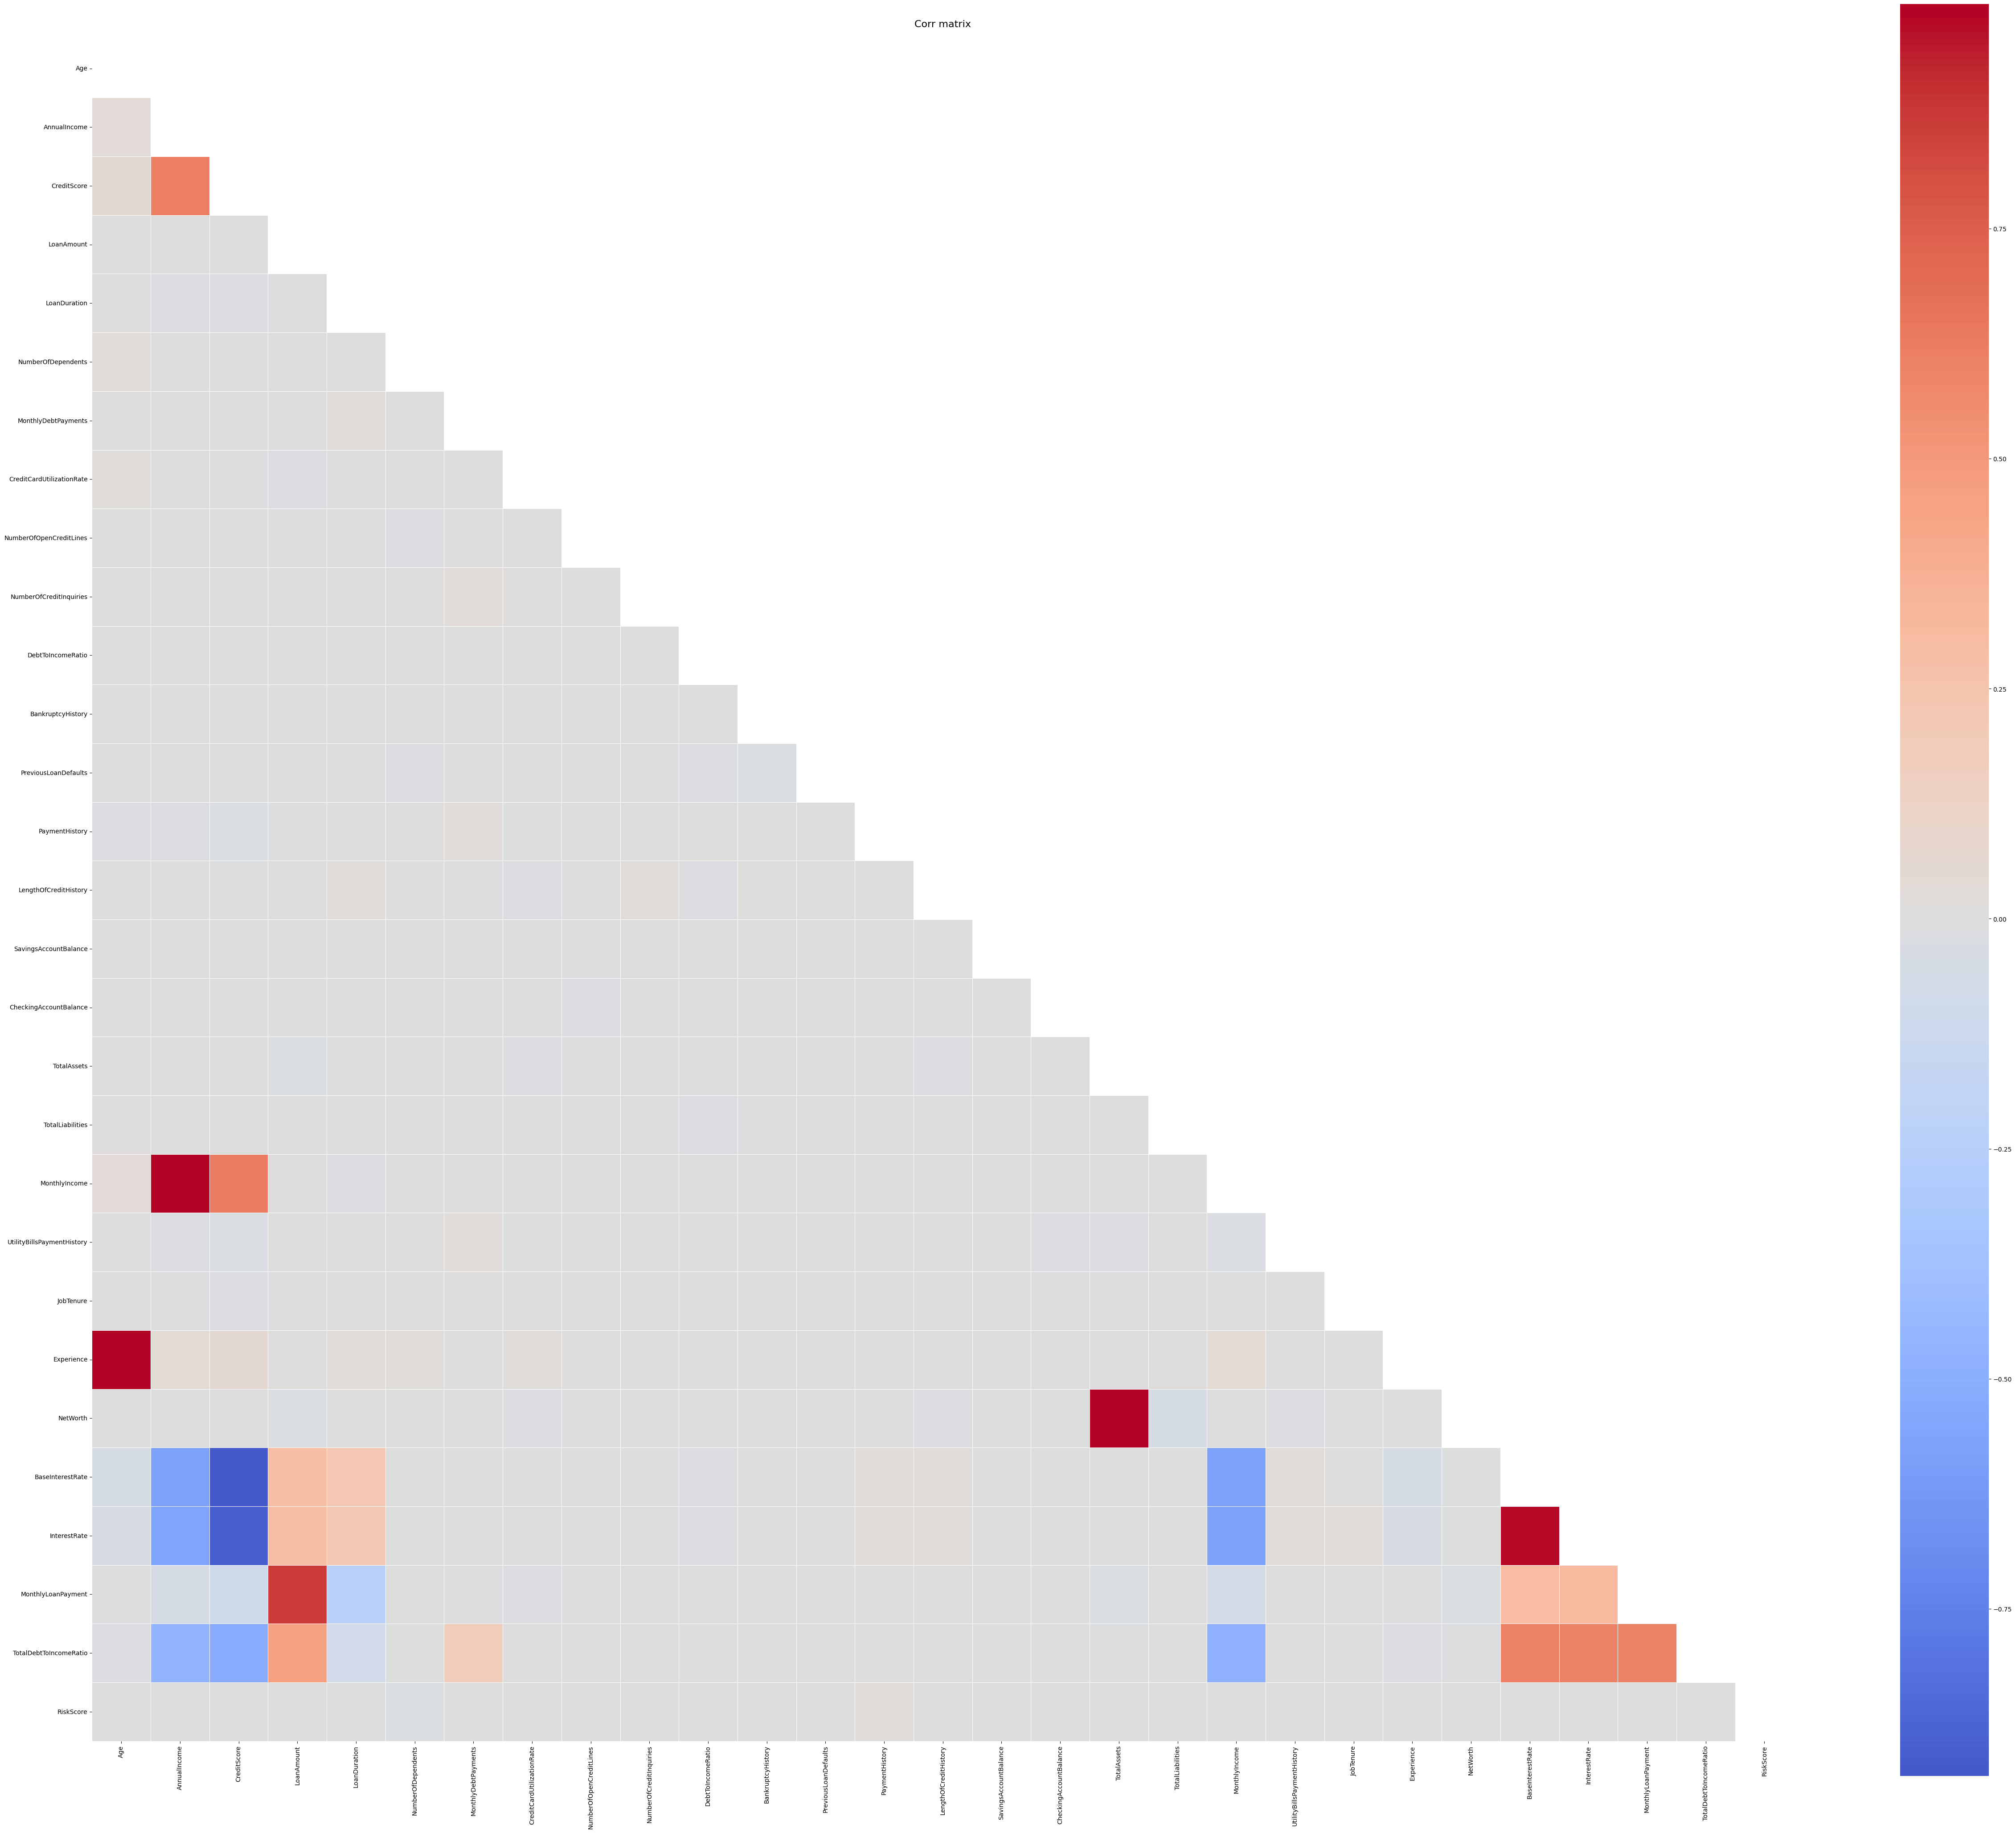

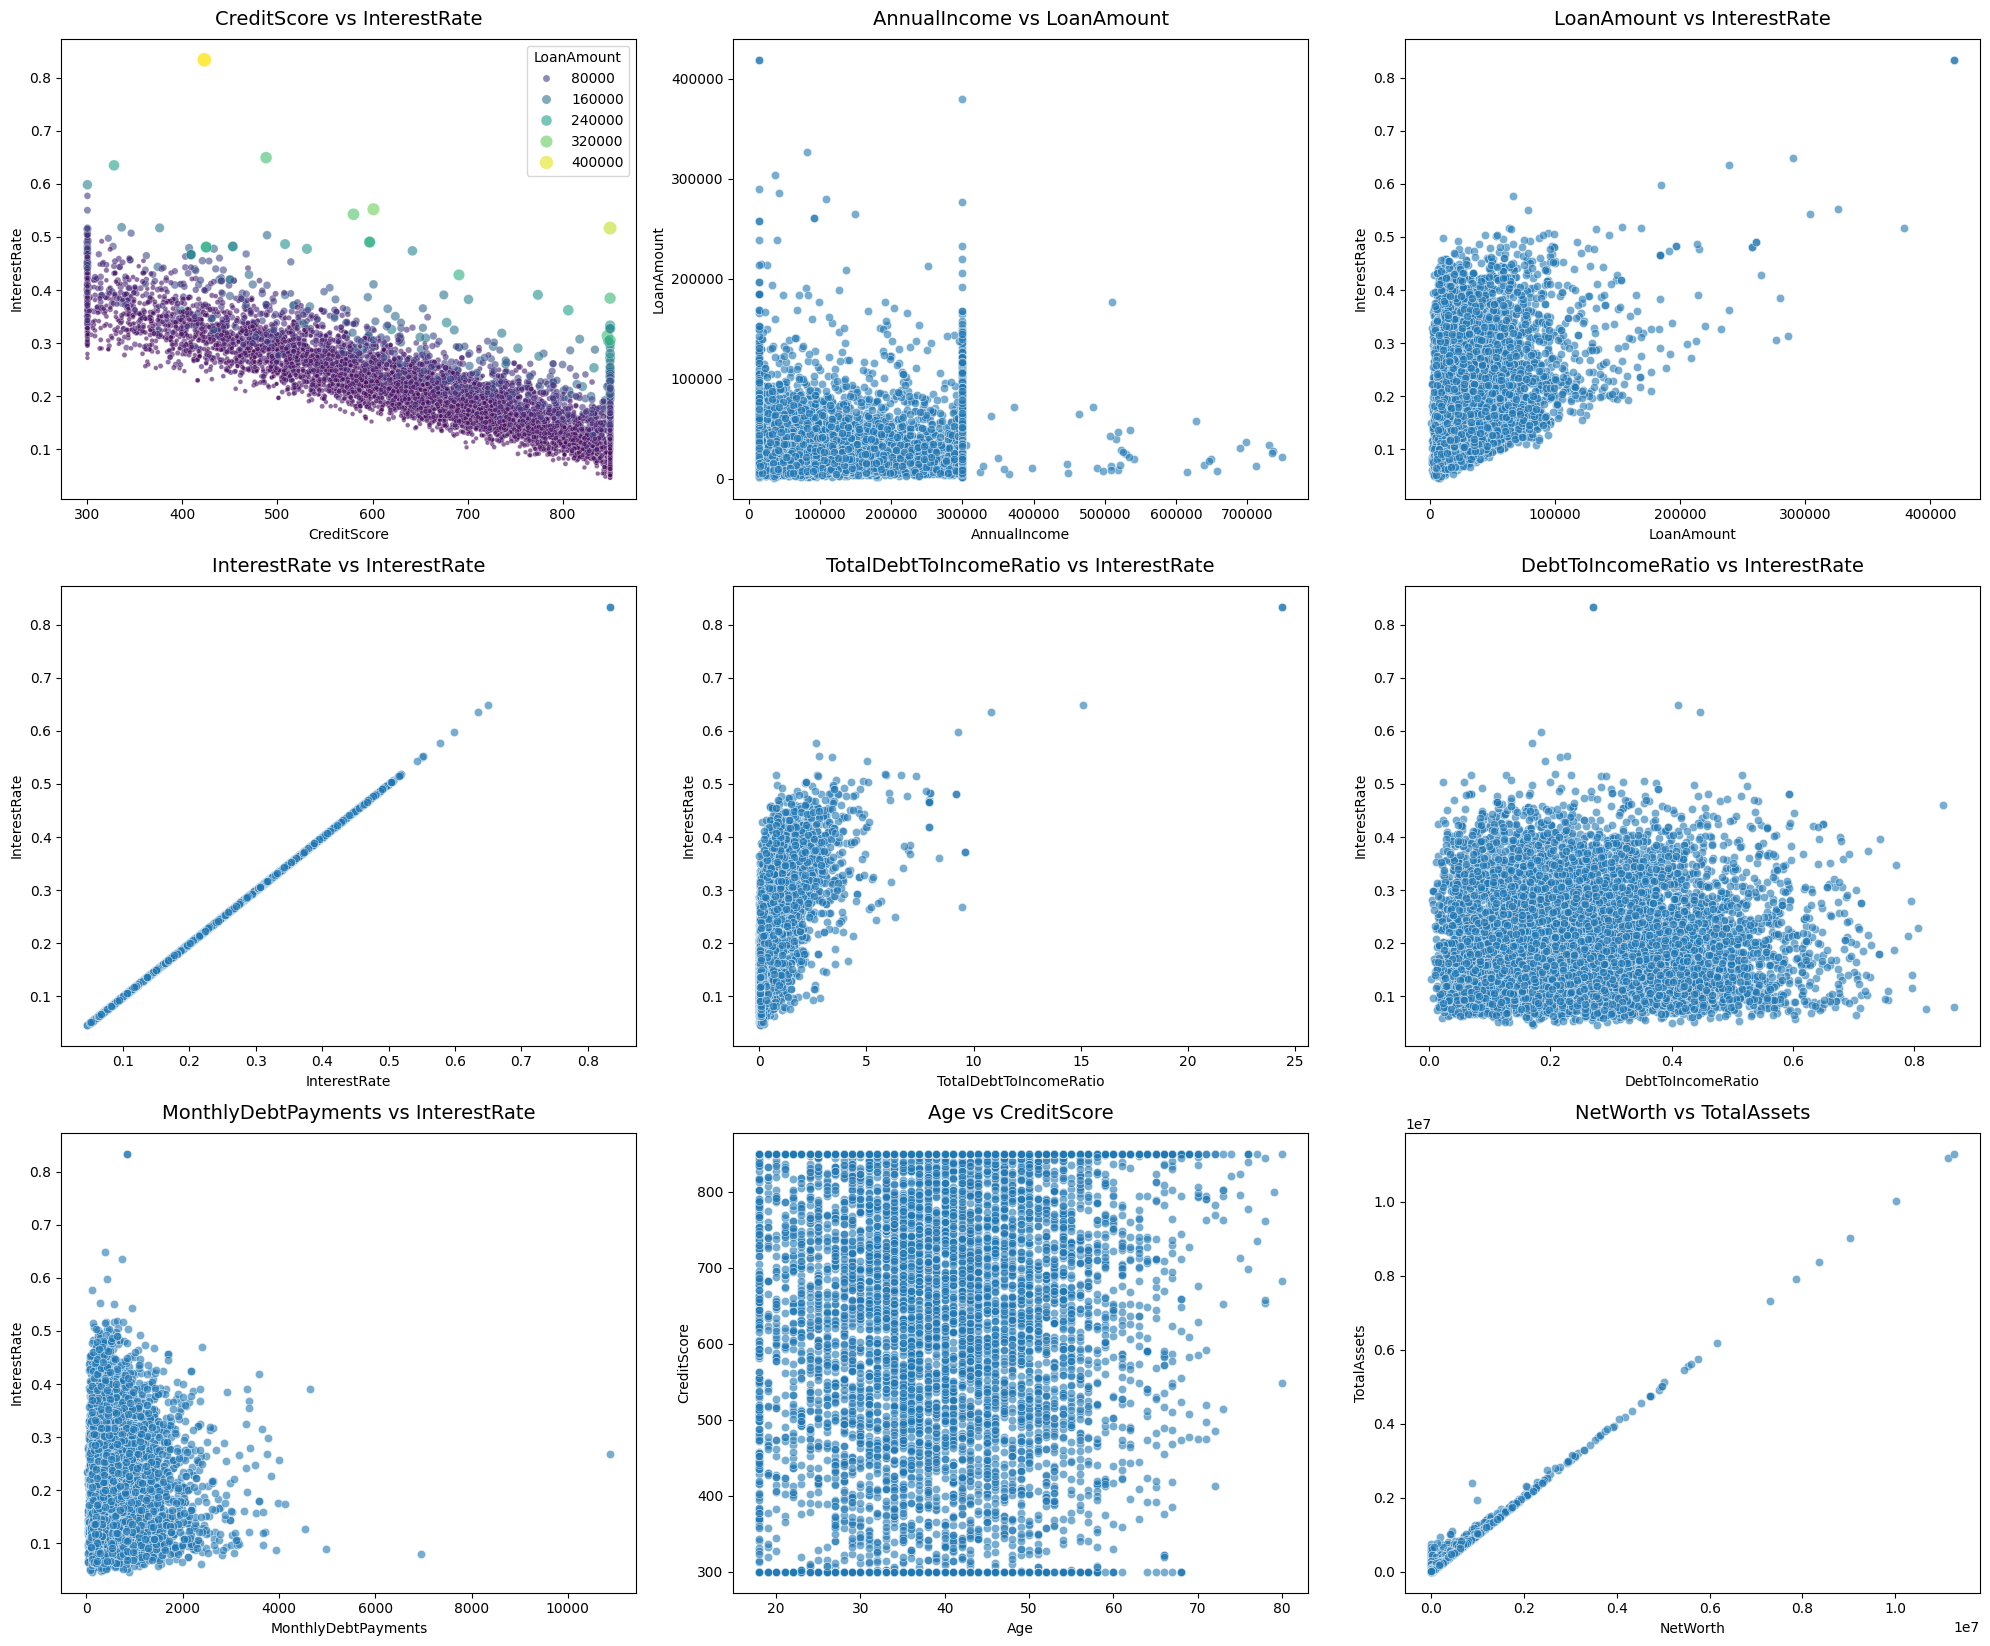

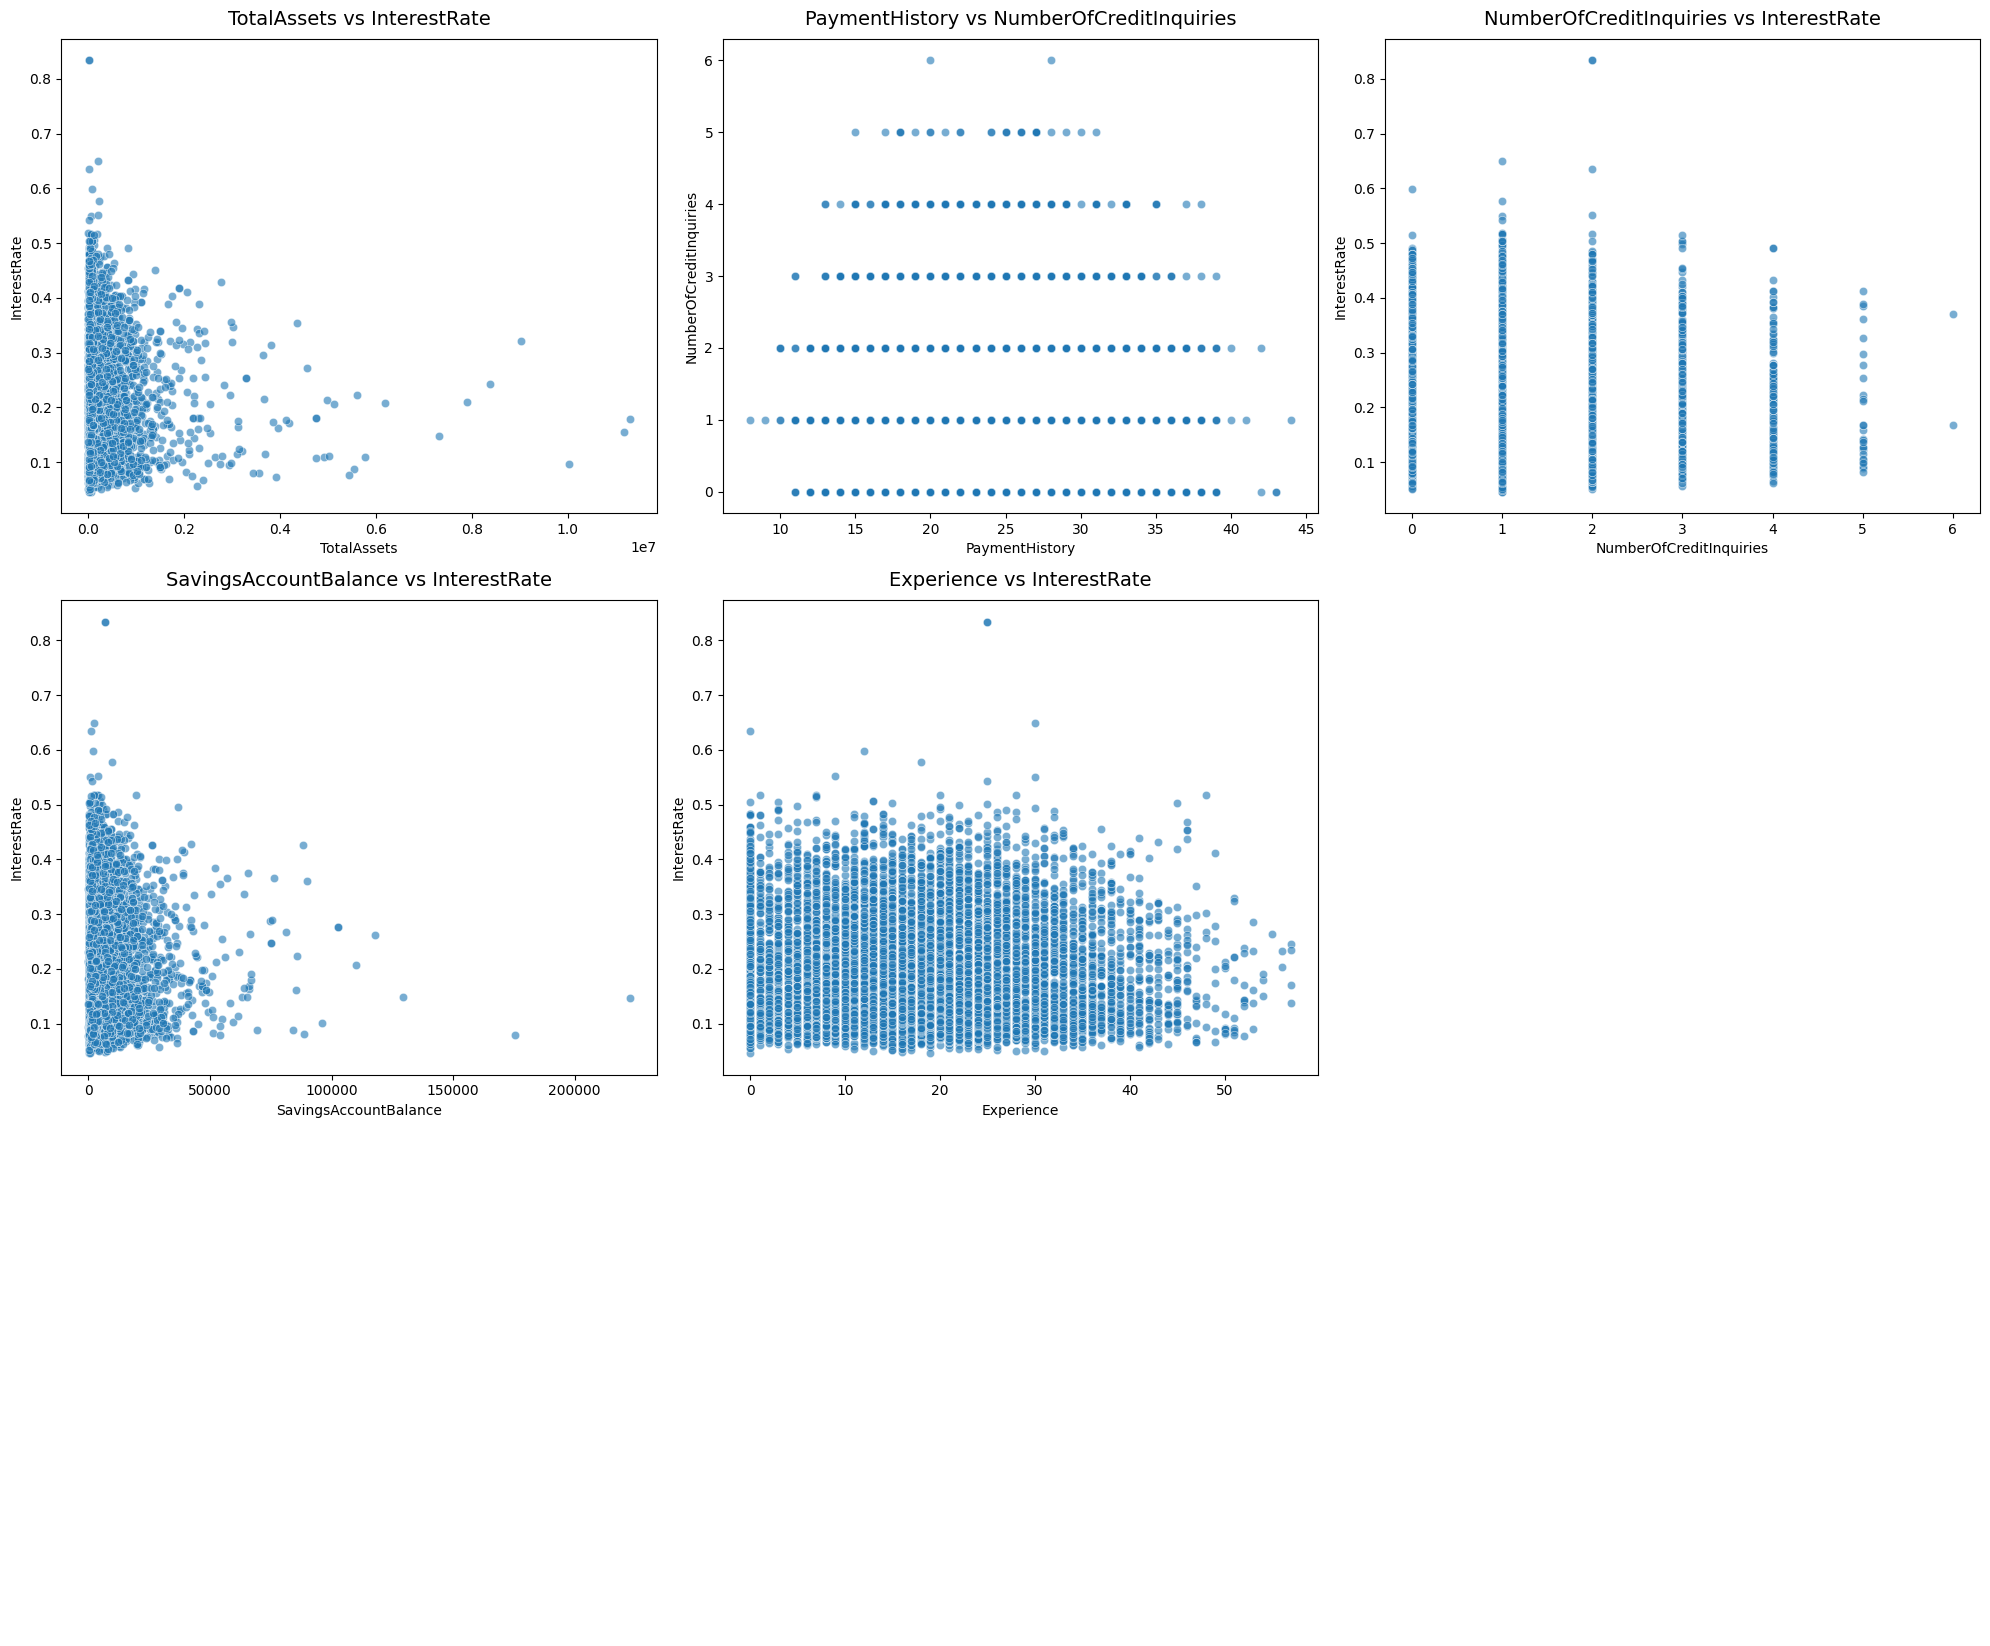

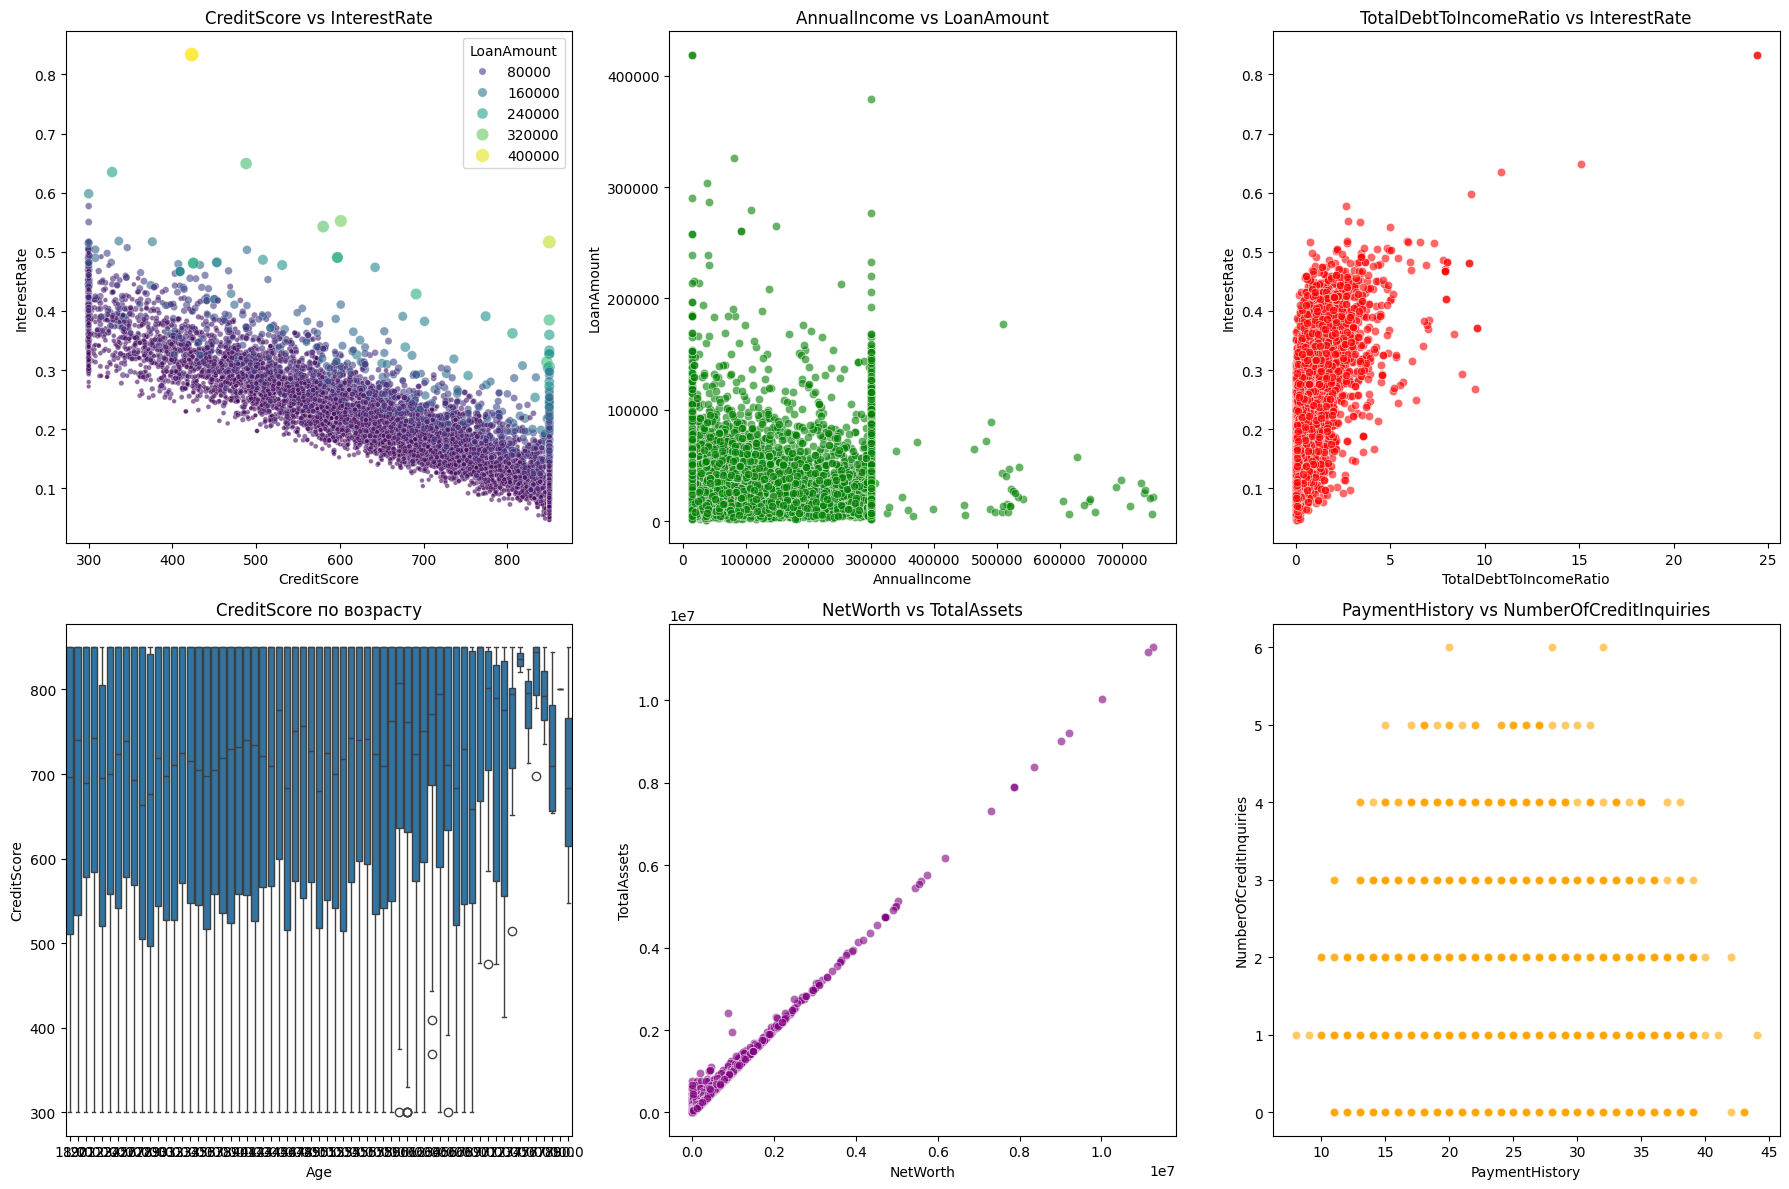

sklearn Cross-validated MSE: 26.5691 ± 1.2376
analytical Cross-validated MSE: 26.6714 ± 1.1858
gd Cross-validated MSE: 30.3254 ± 2.1619
sgd Cross-validated MSE: 30.9469 ± 1.7503
Best method: sklearn with MSE: 26.5691
Saved predictions to C:/Users/mrshv/Desktop/ML/lab1/submission.csv
Testing metrics on a validation split
MSE (sklearn): 25.939798873161823
MSE (custom): 25.939798873161823
MAE (sklearn): 3.6645636016057854
MAE (custom): 3.6645636016057854
R2 (sklearn): 0.9132602786676031
R2 (custom): 0.9132602788087455
MAPE (sklearn): 8.605062068137743
MAPE (custom): 8.604833947470299
Example with minmax scaler
MSE with minmax: 41.95643785751767


In [8]:
output_path = "C:/Users/mrshv/Desktop/ML/lab1/submission.csv"
output_path = "C:/Users/mrshv/Desktop/ML/lab1/submission.csv"

target_column = "RiskScore"
id_column = "ID"

train_path = "C:/Users/mrshv/Desktop/ML/lab1/dataset/train.csv"
test_path = "C:/Users/mrshv/Desktop/ML/lab1/dataset/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

perform_eda(train_df, target_column)
    
train_df = train_df.dropna(subset=[target_column])
train_df = train_df[train_df[target_column].abs() <= 200].reset_index(drop=True)
train_df[target_column] = train_df[target_column].clip(0.0, 100.0)

augment_features(train_df)
augment_features(test_df)

extract_date_parts(train_df, "ApplicationDate")
extract_date_parts(test_df, "ApplicationDate")

education_mapping = {
    'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5
}
if 'EducationLevel' in train_df.columns:
    train_df['EducationLevel'] = train_df['EducationLevel'].map(education_mapping).fillna(0).astype(float)
if 'EducationLevel' in test_df.columns:
    test_df['EducationLevel'] = test_df['EducationLevel'].map(education_mapping).fillna(0).astype(float)

X = train_df.drop(columns=[target_column])
if id_column in X.columns:
    X = X.drop(columns=[id_column])

y = train_df[target_column]

test_ids = (
    test_df[id_column]
    if id_column in test_df.columns
    else pd.Series(np.arange(len(test_df)), name=id_column)
)

X_test = (
    test_df.drop(columns=[id_column])
    if id_column in test_df.columns
    else test_df.copy()
)

numeric_cols = [col for col in X.columns if np.issubdtype(X[col].dtype, np.number)]
cat_cols = [col for col in X.columns if col not in numeric_cols]

methods = ['sklearn', 'analytical', 'gd', 'sgd']
mse_results = {}

cv = CustomCrossValidator(cv_type='kfold', n_splits=5, shuffle=True, random_state=43)

for method in methods:
    mse_scores = []
    verbose = False
    for train_idx, val_idx in cv.split(X):
        X_train = X.iloc[train_idx].copy()
        X_val = X.iloc[val_idx].copy()

        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        pipe = ManualPipeline(reg_method=method, verbose=verbose)
        pipe.fit(X_train, y_train, numeric_cols, cat_cols)

        pred_val = pipe.predict(X_val, numeric_cols, cat_cols)

        mse = np.mean((pred_val - y_val) ** 2)
        mse_scores.append(mse)
    
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mse_results[method] = mean_mse

    print(f"{method} Cross-validated MSE: {mean_mse:.4f} ± {std_mse:.4f}")

best_method = min(mse_results, key=mse_results.get)
print(f"Best method: {best_method} with MSE: {mse_results[best_method]:.4f}")

pipe = ManualPipeline(reg_method=best_method)
pipe.fit(X, y, numeric_cols, cat_cols)

predictions = pipe.predict(X_test, numeric_cols, cat_cols)
predictions = np.clip(predictions, 0.0, 100.0)
submission = pd.DataFrame({
    id_column: test_ids,
    target_column: predictions
})

submission.to_csv(output_path, index=False)
print(f"Saved predictions to {output_path}")
print("Testing metrics on a validation split")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
pipe.fit(X_train, y_train, numeric_cols, cat_cols)
pred_val = pipe.predict(X_val, numeric_cols, cat_cols)

print("MSE (sklearn):", mean_squared_error(y_val, pred_val))
print("MSE (custom):", custom_mse(y_val, pred_val))

print("MAE (sklearn):", mean_absolute_error(y_val, pred_val))
print("MAE (custom):", custom_mae(y_val, pred_val))

print("R2 (sklearn):", r2_score(y_val, pred_val))
print("R2 (custom):", custom_r2(y_val, pred_val))

print("MAPE (sklearn):", mean_absolute_percentage_error(y_val, pred_val) * 100)
print("MAPE (custom):", custom_mape(y_val, pred_val))

print("Example with minmax scaler")

pipe_minmax = ManualPipeline(reg_method=best_method, scaler_type='minmax')
pipe_minmax.fit(X_train, y_train, numeric_cols, cat_cols)
pred_val_minmax = pipe_minmax.predict(X_val, numeric_cols, cat_cols)
print("MSE with minmax:", mean_squared_error(y_val, pred_val_minmax))